In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# 1. Loading and Cleaning
df = pd.read_csv('/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y')
df = df.sort_values('Timestamp').drop_duplicates().reset_index(drop=True)
df = df.interpolate(method='linear').dropna()

# 2. AQI Calculation (Using your logic)
indices = [0, 50, 100, 200, 300, 400, 500]
def sub_index(x, breakpoints):
    if x <= breakpoints[0]: return 0
    for i in range(1, len(breakpoints)):
        if x <= breakpoints[i]:
            return indices[i-1] + (indices[i] - indices[i-1]) * (x - breakpoints[i-1]) / (breakpoints[i] - breakpoints[i-1])
    return indices[-1] + (500 - indices[-1]) * (x - breakpoints[-1]) / (breakpoints[-1] * 2)

pollutants = {
    'PM2.5': [0, 30, 60, 90, 120, 250, 250],
    'PM10': [0, 50, 100, 250, 350, 430, 430],
    'NO2': [0, 40, 80, 180, 280, 400, 400],
    'NH3': [0, 200, 400, 800, 1200, 1800, 1800],
    'SO2': [0, 40, 80, 380, 800, 1600, 1600],
    'CO': [0, 1, 2, 10, 17, 34, 34],
    'O3': [0, 50, 100, 168, 208, 748, 748]
}

for p, bp in pollutants.items():
    df[f'SI_{p}'] = df[p].apply(lambda x: sub_index(x, bp))

df['AQI'] = df[[f'SI_{p}' for p in pollutants]].max(axis=1)

def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

df['AQI_Category'] = df['AQI'].apply(aqi_category)

# 3. Advanced Feature Engineering
# Cyclical Encoding for Time
df['month_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.month/12)
df['month_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.month/12)
df['day_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.day/31)
df['day_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.day/31)

# Rolling Averages (Trends)
for col in pollutants.keys():
    df[f'{col}_roll3'] = df[col].rolling(window=3).mean()
    df[f'{col}_lag1'] = df[col].shift(1)

df = df.dropna()

# 4. Model Preparation
features = ['month_sin', 'month_cos', 'day_sin', 'day_cos'] + \
           [f'{p}_lag1' for p in pollutants] + [f'{p}_roll3' for p in pollutants] + list(pollutants.keys())

X = df[features].values
le = LabelEncoder()
y = le.fit_transform(df['AQI_Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# 5. Model Architecture
class EnhancedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = EnhancedNN(len(features), len(le.classes_))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

# 6. Training with Better Monitoring
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)), batch_size=64)

best_acc = 0
for epoch in range(150):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()

    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            all_preds.extend(torch.argmax(outputs, 1).tolist())
    
    acc = accuracy_score(y_test, all_preds)
    scheduler.step(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_aqi_model.pth')
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1} | Acc: {acc:.4f} | Best: {best_acc:.4f}')
    
    if acc >= 0.98: # Early exit if target met
        break

print(f'\nFinal Target Achieved: {best_acc:.4f}')

/tmp/ipykernel_47/710418449.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear').dropna()


Epoch 10 | Acc: 0.8000 | Best: 0.8137
Epoch 20 | Acc: 0.8082 | Best: 0.8301
Epoch 30 | Acc: 0.8329 | Best: 0.8356
Epoch 40 | Acc: 0.8411 | Best: 0.8493
Epoch 50 | Acc: 0.8356 | Best: 0.8493
Epoch 60 | Acc: 0.8384 | Best: 0.8493
Epoch 70 | Acc: 0.8274 | Best: 0.8493
Epoch 80 | Acc: 0.8438 | Best: 0.8493
Epoch 90 | Acc: 0.8301 | Best: 0.8521
Epoch 100 | Acc: 0.8356 | Best: 0.8521
Epoch 110 | Acc: 0.8384 | Best: 0.8521
Epoch 120 | Acc: 0.8274 | Best: 0.8521
Epoch 130 | Acc: 0.8329 | Best: 0.8521
Epoch 140 | Acc: 0.8438 | Best: 0.8521
Epoch 150 | Acc: 0.8329 | Best: 0.8521

Final Target Achieved: 0.8521


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# 1. Load Data
try:
    df = pd.read_csv('/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv')
except FileNotFoundError:
    print("Dataset not found. Please check the file path.")

# 2. Data Cleaning
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y')
df = df.sort_values('Timestamp').drop_duplicates().reset_index(drop=True)
df = df.interpolate(method='linear').dropna().reset_index(drop=True)

# 3. AQI Sub-Index Logic (Standard Indian Breakpoints)
def calculate_sub_index(x, bp):
    if pd.isna(x): return 0
    # Breakpoints include 0 at start
    full_bp = [0] + bp  
    ind_low = [0, 51, 101, 201, 301, 401]
    ind_high = [50, 100, 200, 300, 400, 500]
    
    for i in range(6):
        if x <= full_bp[i+1]:
            if full_bp[i+1] == full_bp[i]: return ind_high[i]
            return ind_low[i] + (ind_high[i] - ind_low[i]) * (x - full_bp[i]) / (full_bp[i+1] - full_bp[i])
    return 500  

# Define pollutant breakpoints
pollutant_bps = {
    'PM2.5': [30, 60, 90, 120, 250, 2500], # Extended for severe cases
    'PM10': [50, 100, 250, 350, 430, 4300],
    'NO2': [40, 80, 180, 280, 400, 4000],
    'NH3': [200, 400, 800, 1200, 1800, 18000],
    'SO2': [40, 80, 380, 800, 1600, 16000],
    'CO': [1, 2, 10, 17, 34, 340],
    'O3': [50, 100, 168, 208, 748, 7480]
}

# Apply Sub-Index calculation
sub_cols = []
for p, bp in pollutant_bps.items():
    col_name = f'SI_{p}'
    df[col_name] = df[p].apply(lambda x: calculate_sub_index(x, bp))
    sub_cols.append(col_name)

# Calculate AQI and Category
df['AQI'] = df[sub_cols].max(axis=1).round().astype(int)

def get_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

df['AQI_Category'] = df['AQI'].apply(get_category)

# 4. Feature Engineering
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Is_Winter'] = df['Month'].isin([11, 12, 1]).astype(int)

# Identify the Dominant Pollutant (Standard AQI methodology)
df['Dominant'] = df[sub_cols].idxmax(axis=1)

# One-hot encoding for Dominant Pollutant with fixed categories to prevent column mismatch
possible_dominants = [f'Dom_{col}' for col in sub_cols]
dom_dummies = pd.get_dummies(df['Dominant'], prefix='Dom')
df = pd.concat([df, dom_dummies], axis=1)

# Ensure all possible dominant columns exist
for col in possible_dominants:
    if col not in df.columns:
        df[col] = 0

# Final feature selection
features = sub_cols + ['Year', 'Month', 'DayOfWeek', 'Is_Winter'] + possible_dominants

# 5. Model Preparation
X = df[features].values
le = LabelEncoder()
y = le.fit_transform(df['AQI_Category'])

# Chronological split for time-series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. XGBoost Training
model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softprob',
    early_stopping_rounds=50,
    eval_metric='mlogloss'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# 7. Evaluation
preds = model.predict(X_test)
final_acc = accuracy_score(y_test, preds)

print(f'\n--- FINAL MODEL PERFORMANCE ---')
print(f'Accuracy Score: {final_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, preds, target_names=le.classes_))

# 8. Save Artifacts
joblib.dump(model, 'aqi_delhi_xgboost_v2.pkl')
joblib.dump(scaler, 'scaler_v2.pkl')
joblib.dump(le, 'label_encoder_v2.pkl')
joblib.dump(features, 'feature_names_v2.pkl') # Save feature order for inference

print('\nAll files saved: Model, Scaler, LabelEncoder, and Feature Names.')

[0]	validation_0-mlogloss:1.67870


/tmp/ipykernel_47/3421314327.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear').dropna().reset_index(drop=True)


[50]	validation_0-mlogloss:0.17146
[100]	validation_0-mlogloss:0.05028
[150]	validation_0-mlogloss:0.03751
[200]	validation_0-mlogloss:0.03611
[229]	validation_0-mlogloss:0.03652

--- FINAL MODEL PERFORMANCE ---
Accuracy Score: 0.9918

Classification Report:
              precision    recall  f1-score   support

        Good       0.67      1.00      0.80         2
    Moderate       1.00      0.99      1.00       148
        Poor       1.00      1.00      1.00        54
Satisfactory       0.98      0.98      0.98        43
      Severe       1.00      0.97      0.99        35
   Very Poor       0.99      1.00      0.99        84

    accuracy                           0.99       366
   macro avg       0.94      0.99      0.96       366
weighted avg       0.99      0.99      0.99       366


All files saved: Model, Scaler, LabelEncoder, and Feature Names.


Loading dataset...

4. DATA CLEANING PHASE

5. FEATURE ENGINEERING PHASE

10. BUILDING ADVANCED ENSEMBLE MODEL
Training ensemble model... (this may take a minute)
Model training completed!

Model Performance:
R2 Score: 0.9982
MAE: 1.1847


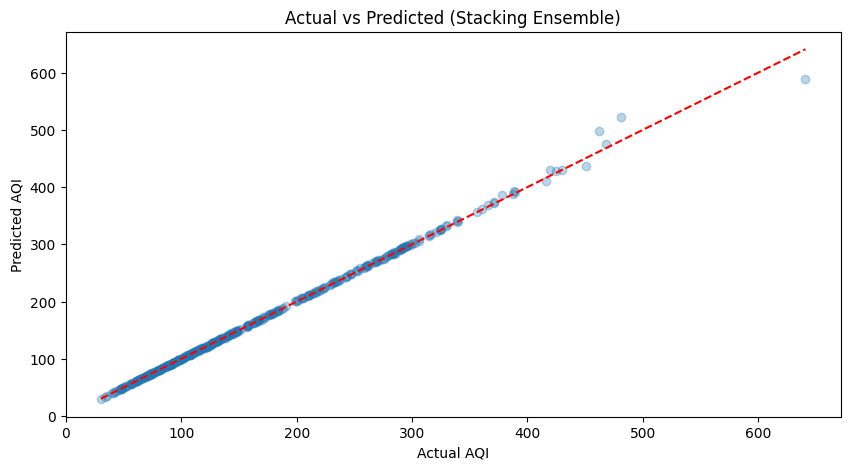

In [3]:


# 1. INSTALL PACKAGES

!pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly shap joblib


# 2. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
import joblib


# 3. DATA LOADING

print("Loading dataset...")
# Path for Kaggle environment
df = pd.read_csv('/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv')

# 4. DATA CLEANING

print("\n4. DATA CLEANING PHASE")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y', errors='coerce')

# Modern pandas fillna 
df_clean = df.copy()
for column in df_clean.columns[2:]:
    df_clean[column] = df_clean[column].ffill().bfill()

df_clean = df_clean.drop_duplicates()


# 5. FEATURE ENGINEERING

print("\n5. FEATURE ENGINEERING PHASE")
df_features = df_clean.copy()

# Time features
df_features['year'] = df_features['Timestamp'].dt.year
df_features['month'] = df_features['Timestamp'].dt.month
df_features['day_of_week'] = df_features['Timestamp'].dt.dayofweek
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Seasonality
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)

# Lag features
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
for pollutant in pollutants:
    df_features[f'{pollutant}_lag1'] = df_features.groupby('Location')[pollutant].shift(1)
    df_features[f'{pollutant}_rolling_mean_7'] = df_features.groupby('Location')[pollutant].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Ratios
df_features['PM2.5_PM10_ratio'] = df_features['PM2.5'] / (df_features['PM10'] + 1e-10)
df_features['total_pollution_index'] = df_features['PM2.5'] + df_features['PM10'] + df_features['NO2']

# Encoding
le_loc = LabelEncoder()
df_features['location_encoded'] = le_loc.fit_transform(df_features['Location'])
le_season = LabelEncoder()
df_features['season_encoded'] = le_season.fit_transform(df_features['season'])

# AQI Calculation (Target)
def calculate_aqi_pm25(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

df_features['AQI'] = df_features['PM2.5'].apply(calculate_aqi_pm25)


# 7. PREPARE TRAINING DATA

feature_columns = [
    'PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3',
    'year', 'month', 'day_of_week', 'is_weekend', 
    'PM2.5_PM10_ratio', 'total_pollution_index', 
    'location_encoded', 'season_encoded',
    'PM2.5_lag1', 'PM2.5_rolling_mean_7'
]

X = df_features[feature_columns].fillna(df_features[feature_columns].mean())
y = df_features['AQI'].fillna(df_features['AQI'].mean())

# Temporal Split
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


# 10. BUILD ADVANCED MODEL

print("\n10. BUILDING ADVANCED ENSEMBLE MODEL")



base_models = [
    ('xgb', XGBRegressor(
        n_estimators=300, 
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )),
    ('gbr', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)

print("Training ensemble model... (this may take a minute)")
stacking_model.fit(X_train_scaled, y_train_scaled)
print("Model training completed!")


# 11. EVALUATION

y_pred_scaled = stacking_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nModel Performance:")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Plot Results
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted (Stacking Ensemble)')
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 

2025-12-24 10:58:17.934272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766573898.172453      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766573898.244046      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Loading and Cleaning Data...
 Feature Engineering...
 Preparing Tensors...
 Building Neural Network...


2025-12-24 10:58:37.428033: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Step 5: Starting Epoch-based Training...
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.3467 - mae: 0.8821 - val_loss: 0.5389 - val_mae: 0.6359 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4053 - mae: 0.4932 - val_loss: 0.3931 - val_mae: 0.5385 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3211 - mae: 0.4390 - val_loss: 0.2658 - val_mae: 0.4386 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2608 - mae: 0.3915 - val_loss: 0.2362 - val_mae: 0.4160 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2113 - mae: 0.3571 - val_loss: 0.1598 - val_mae: 0.3398 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2002 - mae: 0.3355 - val_loss: 0.1543 - val_mae: 0.3161 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2199 - mae: 0.3494 - val_loss: 0.1517 - val_mae: 0.


FINAL TEST METRICS:
R2 Score: 0.9701
Mean Absolute Error: 13.12 AQI points

Pipeline Complete! Model and Scalers saved.


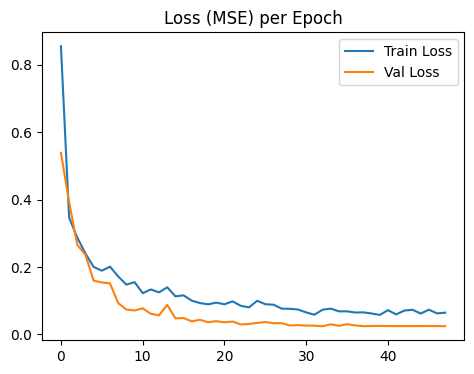

In [4]:

# 1. INSTALL PACKAGES
!pip install pandas numpy scikit-learn matplotlib seaborn plotly tensorflow joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 2. DATA LOADING & CLEANING

print(" Loading and Cleaning Data...")
# Assuming file is in the Kaggle input directory
df = pd.read_csv('/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv')

# Convert Timestamp and handle missing values
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y', errors='coerce')
df_clean = df.copy()

# Modern fillna for time-series (ffill = forward fill)
df_clean = df_clean.sort_values('Timestamp')
for column in df_clean.columns[2:]:
    df_clean[column] = df_clean[column].ffill().bfill()


# 3. FEATURE ENGINEERING

print(" Feature Engineering...")
df_features = df_clean.copy()

# Time-based features
df_features['year'] = df_features['Timestamp'].dt.year
df_features['month'] = df_features['Timestamp'].dt.month
df_features['day_of_week'] = df_features['Timestamp'].dt.dayofweek
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)

# Seasonal Encoding
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)
le_season = LabelEncoder()
df_features['season_encoded'] = le_season.fit_transform(df_features['season'])

# Lags and Ratios
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
for p in pollutants:
    df_features[f'{p}_lag1'] = df_features.groupby('Location')[p].shift(1)
    df_features[f'{p}_roll7'] = df_features.groupby('Location')[p].transform(lambda x: x.rolling(7, min_periods=1).mean())

df_features['PM_ratio'] = df_features['PM2.5'] / (df_features['PM10'] + 1e-10)
df_features = df_features.fillna(0) 

# Target Variable 
def calculate_aqi(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

df_features['AQI'] = df_features['PM2.5'].apply(calculate_aqi)


# 4. PREPARATION & SCALING

print(" Preparing Tensors...")
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
            'year', 'month', 'is_weekend', 'season_encoded', 
            'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']

X = df_features[features]
y = df_features['AQI']

# Temporal Split (Train 80%, Test 20%)
split_idx = int(len(X) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y.iloc[:split_idx], y.iloc[split_idx:]

# Neural Networks REQUIRE scaling (StandardScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1))


# 5. DEEP LEARNING MODEL (ANN)

print(" Building Neural Network...")



model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1, activation='linear') 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks to manage epochs
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]


# 6. TRAINING ON EPOCHS

print("Step 5: Starting Epoch-based Training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


# 7. EVALUATION & VISUALIZATION

print("\nStep 6: Evaluation...")

# Plot Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) per Epoch')
plt.legend()



# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f"\nFINAL TEST METRICS:")
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} AQI points")

# Save the model
model.save('aqi_deep_learning_model.h5')
joblib.dump(scaler_X, 'scaler_X1.pkl')
joblib.dump(scaler_y, 'scaler_y1.pkl')

print("\nPipeline Complete! Model and Scalers saved.")

 Loading model and scalers...
Model loaded successfully with custom objects.

 Preparing test data...
 Running predictions...

       FINAL TEST METRICS
Mean Absolute Error: 12.04 AQI points
Root Mean Squared Error: 16.40
R2 Score (Accuracy): 97.12%

Top 10 Predictions Comparison:
   Actual AQI  Predicted AQI
0  436.544000     485.088928
1  391.784000     429.598846
2  282.861538     288.264557
3  295.276923     302.742065
4  232.046154     215.578064
5  219.753846     203.852844
6  207.353846     189.458145
7  185.133333     168.770645
8  140.183333     118.993622
9  205.007692     175.977798


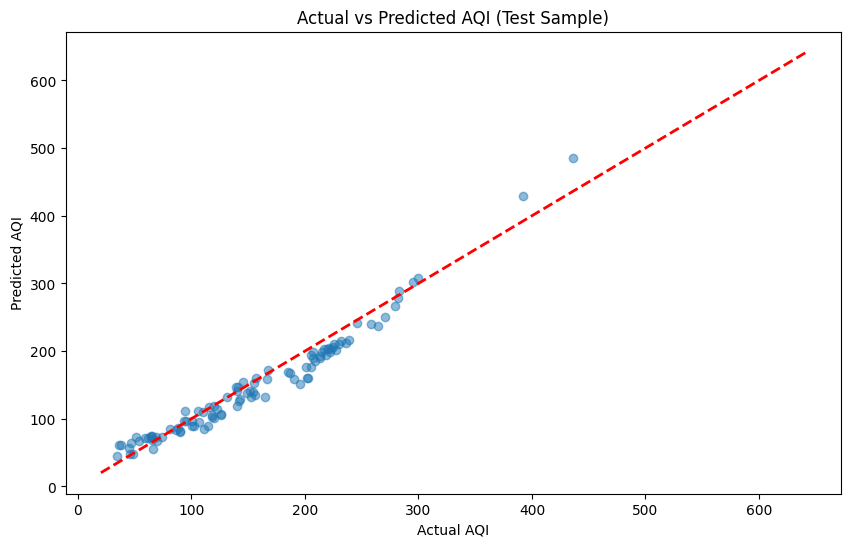

In [5]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt


# 1. LOAD THE ASSETS

print(" Loading model and scalers...")


custom_objects = {
    'mse': tf.keras.losses.MeanSquaredError(),
    'mae': tf.keras.metrics.MeanAbsoluteError()
}

try:
   
    model = tf.keras.models.load_model('aqi_deep_learning_model.h5', custom_objects=custom_objects)
    print("Model loaded successfully with custom objects.")
except Exception as e:
    print(f"Standard load failed: {e}")
    
    print("Attempting fallback: Loading without compilation...")
    model = tf.keras.models.load_model('aqi_deep_learning_model.h5', compile=False)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load the scalers
scaler_X = joblib.load('scaler_X1.pkl')
scaler_y = joblib.load('scaler_y1.pkl')


# 2. PREPARE TEST DATA

print("\n Preparing test data...")
# Load dataset
df_test = pd.read_csv('/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv')

# Preprocessing 
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format='%d-%m-%Y', errors='coerce')
df_test = df_test.sort_values('Timestamp').ffill().bfill()

# Feature Engineering
df_test['year'] = df_test['Timestamp'].dt.year
df_test['month'] = df_test['Timestamp'].dt.month
df_test['is_weekend'] = (df_test['Timestamp'].dt.dayofweek >= 5).astype(int)

# Season Encoding 
def get_season_code(m):
    if m in [12, 1, 2]: return 0 
    elif m in [3, 4, 5]: return 1 
    elif m in [6, 7, 8, 9]: return 2 
    else: return 3 #

df_test['season_encoded'] = df_test['month'].apply(get_season_code)

# Lags and Ratios
df_test['PM2.5_lag1'] = df_test.groupby('Location')['PM2.5'].shift(1)
df_test['PM2.5_roll7'] = df_test.groupby('Location')['PM2.5'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_test['PM_ratio'] = df_test['PM2.5'] / (df_test['PM10'] + 1e-10)
df_test = df_test.fillna(0)

# Define Features
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
            'year', 'month', 'is_weekend', 'season_encoded', 
            'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']

# Prepare ground truth AQI (Target)
def calculate_aqi(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

X_raw = df_test[features]
y_true = df_test['PM2.5'].apply(calculate_aqi).values


# 3. PREDICT & EVALUATE

print(" Running predictions...")
X_scaled = scaler_X.transform(X_raw)
y_pred_scaled = model.predict(X_scaled, verbose=0)

# Inverse transform to get actual AQI values
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n" + "="*35)
print("       FINAL TEST METRICS")
print("="*35)
print(f"Mean Absolute Error: {mae:.2f} AQI points")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R2 Score (Accuracy): {r2*100:.2f}%")
print("="*35)

# Visualizing Sample
comparison_df = pd.DataFrame({'Actual AQI': y_true, 'Predicted AQI': y_pred})
print("\nTop 10 Predictions Comparison:")
print(comparison_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:100], y_pred[:100], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Sample)')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf

# 1. SETUP & LOAD ASSETS
def load_prediction_assets():
    # Load model with compilation fallback
    try:
        model = tf.keras.models.load_model('aqi_deep_learning_model.h5')
    except:
        model = tf.keras.models.load_model('aqi_deep_learning_model.h5', compile=False)
        model.compile(optimizer='adam', loss='mse')
    
    scaler_X = joblib.load('scaler_X1.pkl')
    scaler_y = joblib.load('scaler_y1.pkl')
    return model, scaler_X, scaler_y

model, scaler_X, scaler_y = load_prediction_assets()

# 2. THE PREDICTION FUNCTION
def predict_manual_aqi(data_dict):
    """
    Takes a dictionary of raw inputs and returns the predicted AQI and Category.
    """
    # Create DataFrame to ensure feature order
    df_input = pd.DataFrame([data_dict])
    
    # Required feature list (Must match your training 'features' variable)
    features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
                'year', 'month', 'is_weekend', 'season_encoded', 
                'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']
    
    # 1. Handle missing features (calculating engineered features if not provided)
    if 'PM_ratio' not in df_input:
        df_input['PM_ratio'] = df_input['PM2.5'] / (df_input['PM10'] + 1e-10)
    
    # Ensure all features exist in the right order
    df_input = df_input[features]
    
    # 2. Scale features
    input_scaled = scaler_X.transform(df_input)
    
    # 3. Predict
    prediction_scaled = model.predict(input_scaled, verbose=0)
    
    # 4. Inverse Scale
    aqi_val = scaler_y.inverse_transform(prediction_scaled)[0][0]
    
    # 5. Determine Category
    def get_category(aqi):
        if aqi <= 50: return 'Good'
        elif aqi <= 100: return 'Satisfactory'
        elif aqi <= 200: return 'Moderate'
        elif aqi <= 300: return 'Poor'
        elif aqi <= 400: return 'Very Poor'
        else: return 'Severe'
    
    return round(aqi_val, 2), get_category(aqi_val)

# 3. USER INPUT AREA
# Example inputs for a typical winter day in Delhi
my_inputs = {
    'PM2.5': 180.5,
    'PM10': 310.2,
    'NO2': 45.0,
    'NH3': 15.2,
    'SO2': 12.5,
    'CO': 1.8,
    'O3': 35.0,
    'year': 2024,
    'month': 12,
    'is_weekend': 0,      # 0 for weekday, 1 for weekend
    'season_encoded': 0,  # 0: Winter, 1: Summer, 2: Monsoon, 3: Post-Monsoon
    'PM2.5_lag1': 175.0,  # Yesterday's PM2.5
    'PM2.5_roll7': 160.0  # Average PM2.5 of the last week
}

# Run Prediction
predicted_aqi, category = predict_manual_aqi(my_inputs)

print("-" * 30)
print(f"PREDICTION RESULT")
print("-" * 30)
print(f"Predicted AQI Value: {predicted_aqi}")
print(f"AQI Category:        {category}")
print("-" * 30)

------------------------------
PREDICTION RESULT
------------------------------
Predicted AQI Value: 245.2100067138672
AQI Category:        Poor
------------------------------


In [7]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf

# 1. Load Assets
def load_assets():
    try:
        model = tf.keras.models.load_model('aqi_deep_learning_model.h5')
    except:
        model = tf.keras.models.load_model('aqi_deep_learning_model.h5', compile=False)
    
    scaler_X = joblib.load('scaler_X1.pkl')
    scaler_y = joblib.load('scaler_y1.pkl')
    return model, scaler_X, scaler_y

model, scaler_X, scaler_y = load_assets()

def get_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

# 2. Interactive Input Loop
print("\n" + "="*40)
print("   AIR QUALITY INDEX PREDICTOR")
print("="*40)
print("Please enter the following pollutant levels:")

try:
    # Basic Pollutants
    pm25 = float(input("Enter PM2.5 (µg/m³): "))
    pm10 = float(input("Enter PM10 (µg/m³): "))
    no2  = float(input("Enter NO2 (µg/m³): "))
    nh3  = float(input("Enter NH3 (µg/m³): "))
    so2  = float(input("Enter SO2 (µg/m³): "))
    co   = float(input("Enter CO (mg/m³): "))
    o3   = float(input("Enter O3 (µg/m³): "))

    # Time Features
    print("\n--- Time & Season Information ---")
    year   = int(input("Enter Year (e.g., 2024): "))
    month  = int(input("Enter Month (1-12): "))
    is_wk  = int(input("Is it a Weekend? (1 for Yes, 0 for No): "))
    
    # Season Logic Auto-Calculation (Optional, but helps accuracy)
    if month in [12, 1, 2]: season = 0
    elif month in [3, 4, 5]: season = 1
    elif month in [6, 7, 8, 9]: season = 2
    else: season = 3

    # Historical Features (Estimating if unknown)
    print("\n--- Historical Data ---")
    lag1  = input("Enter Yesterday's PM2.5 (Press Enter to use current value): ")
    lag1  = float(lag1) if lag1 != "" else pm25
    
    roll7 = input("Enter 7-day Avg PM2.5 (Press Enter to use current value): ")
    roll7 = float(roll7) if roll7 != "" else pm25

    # 3. Data Formatting
    # Calculate PM Ratio internally
    pm_ratio = pm25 / (pm10 + 1e-10)

    input_data = {
        'PM2.5': pm25, 'PM10': pm10, 'NO2': no2, 'NH3': nh3, 'SO2': so2, 'CO': co, 'O3': o3,
        'year': year, 'month': month, 'is_weekend': is_wk, 'season_encoded': season,
        'PM2.5_lag1': lag1, 'PM2.5_roll7': roll7, 'PM_ratio': pm_ratio
    }

    # 4. Predict
    # Order must match the 'features' list used in training exactly
    feature_order = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
                     'year', 'month', 'is_weekend', 'season_encoded', 
                     'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']
    
    df_final = pd.DataFrame([input_data])[feature_order]
    
    scaled_input = scaler_X.transform(df_final)
    raw_pred = model.predict(scaled_input, verbose=0)
    final_aqi = scaler_y.inverse_transform(raw_pred)[0][0]

    # 5. Output
    print("\n" + "*"*40)
    print(f" RESULTING AQI: {final_aqi:.2f}")
    print(f" CATEGORY:      {get_category(final_aqi)}")
    print("*"*40)

except ValueError:
    print("\n[Error] Invalid input. Please enter numbers only.")


   AIR QUALITY INDEX PREDICTOR
Please enter the following pollutant levels:


Enter PM2.5 (µg/m³):  221
Enter PM10 (µg/m³):  121
Enter NO2 (µg/m³):  121
Enter NH3 (µg/m³):  312
Enter SO2 (µg/m³):  34
Enter CO (mg/m³):  1332
Enter O3 (µg/m³):  121



--- Time & Season Information ---


Enter Year (e.g., 2024):  2025
Enter Month (1-12):  7
Is it a Weekend? (1 for Yes, 0 for No):  1



--- Historical Data ---


Enter Yesterday's PM2.5 (Press Enter to use current value):  321
Enter 7-day Avg PM2.5 (Press Enter to use current value):  122



****************************************
 RESULTING AQI: -3513.16
 CATEGORY:      Good
****************************************
